# m1: Arm UNICEF Disaster Vulnerability Challenge

https://zindi.africa/competitions/arm-unicef-disaster-vulnerability-challenge

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
import re
import matplotlib.patches as patches
!pip install ultralytics -qq
from ultralytics import YOLO
import os
import yaml


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import pandas as pd
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt


Import data

In [9]:
train = pd.read_csv("/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Train.csv")
test = pd.read_csv("/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Test.csv")

train.head()

,image_id,bbox,category_id,id
0,id_w55q2qr62fsk,"[122.0, 1.0, 42.0, 30.0]",2.0,6356.0
1,id_fvldv7o1kn9d,"[500.0, 141.0, 74.0, 70.0]",2.0,2305.0
2,id_5d1r9l1jp7b5,"[304.0, 525.0, 54.0, 58.0]",2.0,238.0
3,id_45qru79t6s4n,"[187.0, 298.0, 44.0, 56.0]",2.0,921.0
4,id_84cjf2pbqmtv,"[349.0, 721.0, 58.0, 59.0]",2.0,1362.0


In [10]:
train.dropna(inplace=True)

In [11]:
unique_images = train['image_id'].unique()
val_size = int(len(unique_images) * 0.2)

train_imgs = unique_images[:(len(unique_images) - val_size)]
val_imgs = unique_images[-val_size:]

train_idx = np.isin(train['image_id'].values, train_imgs)
val_idx = np.isin(train['image_id'].values, val_imgs)

train_df = train.iloc[train_idx]
val_df = train.iloc[val_idx]


In [12]:
train_df.head()

,image_id,bbox,category_id,id
0,id_w55q2qr62fsk,"[122.0, 1.0, 42.0, 30.0]",2.0,6356.0
1,id_fvldv7o1kn9d,"[500.0, 141.0, 74.0, 70.0]",2.0,2305.0
2,id_5d1r9l1jp7b5,"[304.0, 525.0, 54.0, 58.0]",2.0,238.0
3,id_45qru79t6s4n,"[187.0, 298.0, 44.0, 56.0]",2.0,921.0
4,id_84cjf2pbqmtv,"[349.0, 721.0, 58.0, 59.0]",2.0,1362.0


In [13]:
sample_img = "id_5d1r9l1jp7b5"

In [14]:
image_df = train_df[train_df['image_id'] == sample_img]

In [15]:
image_df.head()

,image_id,bbox,category_id,id
2,id_5d1r9l1jp7b5,"[304.0, 525.0, 54.0, 58.0]",2.0,238.0
1773,id_5d1r9l1jp7b5,"[2.0, 815.0, 65.0, 65.0]",2.0,242.0
2248,id_5d1r9l1jp7b5,"[516.0, 42.0, 40.0, 74.0]",2.0,248.0
7305,id_5d1r9l1jp7b5,"[106.0, 411.0, 57.0, 51.0]",2.0,247.0
7734,id_5d1r9l1jp7b5,"[185.0, 459.0, 55.0, 52.0]",2.0,236.0


In [16]:
def decode_points(ddbox: str) -> list:
    points = [np.float32(point) for point in re.findall(r'\d+\.\d+', ddbox)]
    return points


def plot_image_with_bbox(image_path, bboxes):
    img = Image.open(image_path)

    fig, ax = plt.subplots(1)

    ax.imshow(img)

    for bbox in bboxes:
        x, y, w, h = decode_points(bbox)
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

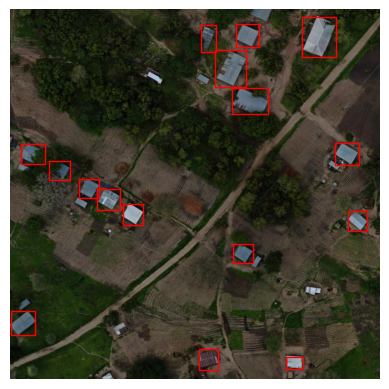

In [17]:
img_path = f"/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images/{sample_img}.tif"

plot_image_with_bbox(img_path, image_df['bbox'].values)

In [18]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])


In [19]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0] + '.tif') 
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 2]) - 1  

        if self.transform:
            image = self.transform(image)

        return image, label


In [20]:

train_dataset = CustomDataset(dataframe=train_df, image_dir="/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)


val_dataset = CustomDataset(dataframe=val_df, image_dir="/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [21]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Split the data in YOLO format

In [22]:
#check for null values
for col in train_df:
    print(col, train_df[col].isnull().sum())

image_id 0
bbox 0
category_id 0
id 0


In [24]:
import shutil

In [25]:
copy_from_folder = "/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images"

In [26]:
#copy the images to their respective data folders
def create_data_folder(destination_folder, df):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        
    unique_images = df['image_id'].unique()
    
    for img in unique_images:
        img_path = os.path.join(copy_from_folder, img + '.tif')
        shutil.copy(img_path, destination_folder)

In [27]:
train_destination_folder = "/kaggle/working/train/images"
val_destination_folder = "/kaggle/working/val/images"

In [28]:
create_data_folder(train_destination_folder, train_df)
create_data_folder(val_destination_folder, val_df)

In [29]:
img = Image.open("/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images/id_00qr9gisgz51.tif")
img.width, img.height

(500, 500)

In [30]:
img_width = 500
img_height = 500

In [31]:
from tqdm import tqdm

In [32]:
#scale the dataset to the YOLO format
def convert_bbox_to_string(bbox):
    box = decode_points(bbox)
    w = box[2]
    h = box[3]
    xc = box[0] + int(np.round(w/2))
    yc = box[1] + int(np.round(h/2))
    box = [xc/img_width, yc/img_height, w/img_width, h/img_height]
    box = [f"{i:.4g}" for i in box]
    return " ".join(box)

In [33]:
def create_label_folder(label_dir, dataframe):
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
        
    unique_images = dataframe['image_id'].unique()
    
    for i,img in zip(tqdm(range(len(unique_images))), unique_images):
        df = dataframe[dataframe['image_id'] == img]
        output_lines = []
        for index, row in df.iterrows():
            category_id = int(row['category_id']) - 1

            bbox_string = convert_bbox_to_string(row['bbox'])
            output_lines.append(f'{category_id} {bbox_string}')

        with open(f"{label_dir}/{img}.txt", 'w') as f:
            for line in output_lines:
                f.write(line + '\n')

In [34]:
create_label_folder("/kaggle/working/train/labels", train_df)
create_label_folder("/kaggle/working/val/labels", val_df)

100%|██████████| 493/493 [00:00<00:00, 1349.49it/s]


In [35]:
num_classes = 3
names = ["Thatch", "Tin", "Other"]
train_dest_dir = "/kaggle/working/train"
val_dest_dir = "/kaggle/working/val"
dict_file = {
    'train': train_dest_dir,
    'val' : val_dest_dir,
    'nc': num_classes,
    'names': names
    }

with open("/kaggle/working/data.yaml", 'w+') as file:
    yaml.dump(dict_file, file)

In [36]:
### read yaml file created
def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

yaml_data = read_yaml_file("/kaggle/working/data.yaml")

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Thatch
- Tin
- Other
nc: 3
train: /kaggle/working/train
val: /kaggle/working/val



### Train

In [37]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 81.9MB/s]


In [43]:
EPOCHS = 2
BATCH_SIZE = 32
OPTIMIZER = "auto"
SEED = 42
NAME = f"Arm_Yolo_{EPOCHS}"
DEVICE = [0]
VERBOSE = False
RESUME = False
PATIENCE = 20


### train
model.train(
    data = "/kaggle/working/data.yaml",
    task = 'detect',
    imgsz = (img_height, img_width),
    epochs = EPOCHS,
    batch = BATCH_SIZE,
    optimizer = OPTIMIZER,
    patience = PATIENCE,
    name = NAME,
    seed = SEED,
    val = True,
    resume = RESUME,
    device = DEVICE,
    verbose = VERBOSE
)

Ultralytics 8.3.61 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=2, time=None, patience=20, batch=32, imgsz=(500, 500), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=Arm_Yolo_2, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

train: Scanning /kaggle/working/train/labels.cache... 1972 images, 0 backgrounds, 1300 corrupt: 100%|██████████| 1972/1972 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/train/images/id_00w4th51hio0.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        1.2       1.038       1.402]
train: WARNING ⚠️ /kaggle/working/train/images/id_01gz1pz8e9w6.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.274       1.108       1.266        1.49]
train: WARNING ⚠️ /kaggle/working/train/images/id_030hekikfdhm.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.19       1.744       1.344       1.356       1.148       1.286       1.384       1.326       1.792        1.41        1.51]
train: WARNING ⚠️ /kaggle/working/train/images/id_03pk9khicf1n.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [       1.66       1.204       1.124       1.148       1.928       1.508       1.344]
train: WARNING ⚠️ /kaggle/working/train/images/id_0478ordzao81.tif: ignoring corrupt image/label: non-normalized or out of b


val: Scanning /kaggle/working/val/labels.cache... 493 images, 0 backgrounds, 248 corrupt: 100%|██████████| 493/493 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/val/images/id_02f9pbs0slgu.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.436       1.638       1.274]
val: WARNING ⚠️ /kaggle/working/val/images/id_02fegt8z95w2.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.512]
val: WARNING ⚠️ /kaggle/working/val/images/id_06r6arlxsrtn.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.322]
val: WARNING ⚠️ /kaggle/working/val/images/id_09xmimyns83j.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.078       1.144]
val: WARNING ⚠️ /kaggle/working/val/images/id_0ct4lhlt5ylt.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.682         1.9]
val: WARNING ⚠️ /kaggle/working/val/images/id_0i54k68jowvb.tif: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.926       1.444]
val: WARNING ⚠️ /kaggle/work

Plotting labels to runs/detect/Arm_Yolo_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/Arm_Yolo_2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      3.99G      1.215      0.709     0.9911        420        512: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        245        468      0.762      0.445      0.416      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      3.27G      1.212       0.69     0.9971        469        512: 100%|██████████| 21/21 [00:04<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        245        468      0.803      0.452        0.5       0.28



2 epochs completed in 0.005 hours.
Optimizer stripped from runs/detect/Arm_Yolo_2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/Arm_Yolo_2/weights/best.pt, 6.2MB

Validating runs/detect/Arm_Yolo_2/weights/best.pt...
Ultralytics 8.3.61 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


                   all        245        468      0.803      0.452        0.5       0.28
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/Arm_Yolo_2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d8ad46ab220>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [48]:
pred = model.predict("/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images/id_04ywt8kphcdv.tif")

In [49]:
pred_json = pred[0].tojson()
pred_json

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


'[\n  {\n    "name": "Tin",\n    "class": 1,\n    "confidence": 0.84323,\n    "box": {\n      "x1": 458.11862,\n      "y1": 149.54987,\n      "x2": 498.98972,\n      "y2": 192.56462\n    }\n  },\n  {\n    "name": "Tin",\n    "class": 1,\n    "confidence": 0.80663,\n    "box": {\n      "x1": 319.42349,\n      "y1": 52.66946,\n      "x2": 357.23715,\n      "y2": 87.6207\n    }\n  },\n  {\n    "name": "Tin",\n    "class": 1,\n    "confidence": 0.80272,\n    "box": {\n      "x1": 427.54385,\n      "y1": 472.98572,\n      "x2": 463.62488,\n      "y2": 500.0\n    }\n  },\n  {\n    "name": "Tin",\n    "class": 1,\n    "confidence": 0.79701,\n    "box": {\n      "x1": 358.0654,\n      "y1": 107.44868,\n      "x2": 402.65359,\n      "y2": 143.01001\n    }\n  },\n  {\n    "name": "Tin",\n    "class": 1,\n    "confidence": 0.76131,\n    "box": {\n      "x1": 427.02069,\n      "y1": 89.66959,\n      "x2": 453.75058,\n      "y2": 119.37169\n    }\n  },\n  {\n    "name": "Tin",\n    "class": 1,\n   

In [45]:
import json
def get_classes_count(pred_json: str):
    classes_count = {}
    classes_count[0] = 0
    classes_count[1] = 0
    classes_count[2] = 0
    for j in json.loads(pred_json):
        classes_count[j['class']] += 1
        
    return classes_count

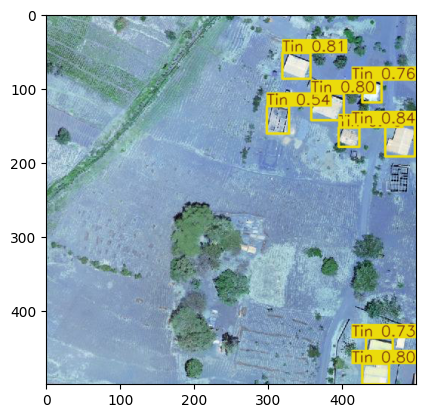

In [50]:
plt.imshow(pred[0].plot())

In [51]:
get_classes_count(pred_json)

{0: 0, 1: 8, 2: 0}

In [52]:
test.head()

,image_id
0,id_uawi0k5spci5
1,id_ba566jv4xzln
2,id_q4odggcgnc77
3,id_4lrqmvmmgier
4,id_sqadni8gqzao


In [54]:
submission_df = pd.DataFrame(columns=["image_id", "Target"])

for index, row in tqdm(test.iterrows(), total=len(test)):
    pred = model.predict(f"/kaggle/input/arm-unicef-disaster-vulnerability-challenge/Images/{row['image_id']}.tif")
    pred_json = get_classes_count(pred[0].tojson())
    
    df = pd.DataFrame({"image_id" : [f"{row['image_id']}_1",
                                     f"{row['image_id']}_2",
                                     f"{row['image_id']}_3"],
                      "Target" : [pred_json[0], pred_json[1], pred_json[2]]},columns=["image_id", "Target"])
    submission_df = pd.concat([submission_df, df], axis = 0)

  0%|          | 0/2045 [00:00<?, ?it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  0%|          | 2/2045 [00:00<01:53, 18.04it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  0%|          | 5/2045 [00:00<01:49, 18.71it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  0%|          | 7/2045 [00:00<01:57, 17.34it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  0%|          | 10/2045 [00:00<01:35, 21.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  1%|          | 13/2045 [00:00<01:36, 21.11it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  1%|          | 16/2045 [00:00<01:27, 23.31it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  1%|          | 19/2045 [00:00<01:29, 22.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  1%|          | 22/2045 [00:01<01:27, 23.18it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  1%|          | 25/2045 [00:01<01:25, 23.68it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  1%|▏         | 28/2045 [00:01<01:20, 25.00it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  2%|▏         | 31/2045 [00:01<01:23, 24.00it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  2%|▏         | 34/2045 [00:01<01:23, 24.18it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  2%|▏         | 37/2045 [00:01<01:28, 22.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  2%|▏         | 40/2045 [00:01<01:34, 21.12it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  2%|▏         | 43/2045 [00:01<01:26, 23.05it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  2%|▏         | 46/2045 [00:02<01:21, 24.39it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  2%|▏         | 49/2045 [00:02<01:24, 23.58it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  3%|▎         | 52/2045 [00:02<01:28, 22.55it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  3%|▎         | 55/2045 [00:02<01:30, 22.03it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  3%|▎         | 58/2045 [00:02<01:33, 21.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  3%|▎         | 61/2045 [00:02<01:33, 21.16it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  3%|▎         | 64/2045 [00:02<01:35, 20.79it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  3%|▎         | 67/2045 [00:02<01:27, 22.73it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  3%|▎         | 70/2045 [00:03<01:32, 21.42it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  4%|▎         | 73/2045 [00:03<01:29, 22.10it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  4%|▎         | 76/2045 [00:03<01:34, 20.89it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  4%|▍         | 79/2045 [00:03<01:30, 21.71it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  4%|▍         | 82/2045 [00:03<01:31, 21.50it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  4%|▍         | 85/2045 [00:03<01:24, 23.25it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  4%|▍         | 88/2045 [00:03<01:31, 21.32it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  4%|▍         | 91/2045 [00:04<01:24, 23.24it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  5%|▍         | 94/2045 [00:04<01:25, 22.72it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  5%|▍         | 97/2045 [00:04<01:21, 23.79it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  5%|▍         | 100/2045 [00:04<01:17, 25.04it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  5%|▌         | 103/2045 [00:04<01:22, 23.44it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  5%|▌         | 106/2045 [00:04<01:21, 23.77it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  5%|▌         | 109/2045 [00:04<01:19, 24.29it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  5%|▌         | 112/2045 [00:04<01:25, 22.66it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  6%|▌         | 115/2045 [00:05<01:21, 23.60it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  6%|▌         | 118/2045 [00:05<01:23, 23.05it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  6%|▌         | 121/2045 [00:05<01:23, 23.12it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  6%|▌         | 124/2045 [00:05<01:26, 22.12it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  6%|▌         | 127/2045 [00:05<01:27, 21.96it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  6%|▋         | 130/2045 [00:05<01:25, 22.45it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  7%|▋         | 133/2045 [00:05<01:28, 21.69it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  7%|▋         | 136/2045 [00:06<01:30, 21.20it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  7%|▋         | 139/2045 [00:06<01:29, 21.27it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  7%|▋         | 142/2045 [00:06<01:28, 21.42it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  7%|▋         | 145/2045 [00:06<01:27, 21.68it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  7%|▋         | 148/2045 [00:06<01:31, 20.79it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  7%|▋         | 151/2045 [00:06<01:37, 19.43it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  8%|▊         | 154/2045 [00:06<01:31, 20.77it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  8%|▊         | 157/2045 [00:07<01:30, 20.90it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  8%|▊         | 161/2045 [00:07<01:17, 24.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  8%|▊         | 164/2045 [00:07<01:19, 23.55it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  8%|▊         | 167/2045 [00:07<01:20, 23.30it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  8%|▊         | 170/2045 [00:07<01:15, 24.77it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  8%|▊         | 173/2045 [00:07<01:16, 24.52it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  9%|▊         | 177/2045 [00:07<01:12, 25.80it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  9%|▉         | 180/2045 [00:07<01:09, 26.83it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  9%|▉         | 183/2045 [00:08<01:14, 24.89it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  9%|▉         | 186/2045 [00:08<01:15, 24.59it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  9%|▉         | 189/2045 [00:08<01:16, 24.31it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


  9%|▉         | 192/2045 [00:08<01:17, 24.05it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 10%|▉         | 195/2045 [00:08<01:14, 24.94it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 10%|▉         | 198/2045 [00:08<01:20, 23.07it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 10%|▉         | 201/2045 [00:08<01:19, 23.22it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 10%|▉         | 204/2045 [00:08<01:14, 24.66it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 10%|█         | 207/2045 [00:09<01:11, 25.64it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 10%|█         | 210/2045 [00:09<01:19, 22.96it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 10%|█         | 213/2045 [00:09<01:19, 23.00it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 11%|█         | 216/2045 [00:09<01:22, 22.27it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 11%|█         | 219/2045 [00:09<01:22, 22.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 11%|█         | 222/2045 [00:09<01:23, 21.91it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 11%|█         | 225/2045 [00:09<01:19, 22.89it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 11%|█         | 228/2045 [00:10<01:16, 23.63it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 11%|█▏        | 231/2045 [00:10<01:12, 24.92it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 11%|█▏        | 234/2045 [00:10<01:18, 23.21it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 12%|█▏        | 237/2045 [00:10<01:18, 23.13it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 12%|█▏        | 240/2045 [00:10<01:13, 24.45it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 12%|█▏        | 243/2045 [00:10<01:11, 25.06it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 12%|█▏        | 246/2045 [00:10<01:12, 24.80it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 12%|█▏        | 249/2045 [00:10<01:13, 24.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 12%|█▏        | 252/2045 [00:10<01:12, 24.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 12%|█▏        | 255/2045 [00:11<01:12, 24.69it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 13%|█▎        | 258/2045 [00:11<01:12, 24.73it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 13%|█▎        | 261/2045 [00:11<01:12, 24.48it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 13%|█▎        | 264/2045 [00:11<01:10, 25.11it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 13%|█▎        | 267/2045 [00:11<01:09, 25.52it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 13%|█▎        | 270/2045 [00:11<01:13, 24.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 13%|█▎        | 273/2045 [00:11<01:13, 24.22it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 13%|█▎        | 276/2045 [00:11<01:11, 24.64it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 14%|█▎        | 279/2045 [00:12<01:12, 24.41it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 14%|█▍        | 282/2045 [00:12<01:08, 25.61it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 14%|█▍        | 285/2045 [00:12<01:10, 25.12it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 14%|█▍        | 288/2045 [00:12<01:13, 23.98it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 14%|█▍        | 291/2045 [00:12<01:14, 23.60it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 14%|█▍        | 294/2045 [00:12<01:15, 23.16it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 15%|█▍        | 297/2045 [00:12<01:11, 24.28it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 15%|█▍        | 300/2045 [00:12<01:12, 24.09it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 15%|█▍        | 303/2045 [00:13<01:18, 22.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 15%|█▍        | 306/2045 [00:13<01:17, 22.42it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 15%|█▌        | 309/2045 [00:13<01:20, 21.59it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 15%|█▌        | 312/2045 [00:13<01:17, 22.24it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 15%|█▌        | 315/2045 [00:13<01:15, 22.84it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 16%|█▌        | 318/2045 [00:13<01:16, 22.44it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 16%|█▌        | 321/2045 [00:13<01:16, 22.48it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 16%|█▌        | 324/2045 [00:14<01:14, 23.13it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 16%|█▌        | 327/2045 [00:14<01:10, 24.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 16%|█▌        | 330/2045 [00:14<01:10, 24.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 16%|█▋        | 333/2045 [00:14<01:15, 22.76it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 16%|█▋        | 336/2045 [00:14<01:13, 23.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 17%|█▋        | 339/2045 [00:14<01:16, 22.38it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 17%|█▋        | 342/2045 [00:14<01:19, 21.41it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 17%|█▋        | 346/2045 [00:14<01:09, 24.32it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 17%|█▋        | 349/2045 [00:15<01:06, 25.38it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 17%|█▋        | 352/2045 [00:15<01:04, 26.07it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 17%|█▋        | 355/2045 [00:15<01:08, 24.64it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 18%|█▊        | 358/2045 [00:15<01:08, 24.76it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 18%|█▊        | 361/2045 [00:15<01:08, 24.42it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 18%|█▊        | 364/2045 [00:15<01:08, 24.50it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 18%|█▊        | 367/2045 [00:15<01:07, 24.75it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 18%|█▊        | 371/2045 [00:15<01:03, 26.20it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 18%|█▊        | 374/2045 [00:16<01:07, 24.87it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 18%|█▊        | 377/2045 [00:16<01:08, 24.30it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 19%|█▊        | 380/2045 [00:16<01:08, 24.18it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 19%|█▊        | 383/2045 [00:16<01:09, 23.76it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 19%|█▉        | 386/2045 [00:16<01:12, 22.82it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 19%|█▉        | 389/2045 [00:16<01:13, 22.54it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 19%|█▉        | 392/2045 [00:16<01:09, 23.63it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 19%|█▉        | 395/2045 [00:16<01:08, 24.25it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 19%|█▉        | 398/2045 [00:17<01:11, 23.10it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 20%|█▉        | 401/2045 [00:17<01:12, 22.64it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 20%|█▉        | 404/2045 [00:17<01:11, 22.91it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 20%|█▉        | 407/2045 [00:17<01:08, 24.01it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 20%|██        | 410/2045 [00:17<01:07, 24.29it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 20%|██        | 413/2045 [00:17<01:13, 22.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 20%|██        | 416/2045 [00:17<01:13, 22.25it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 20%|██        | 419/2045 [00:18<01:10, 23.09it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 21%|██        | 422/2045 [00:18<01:09, 23.39it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 21%|██        | 425/2045 [00:18<01:07, 24.07it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 21%|██        | 428/2045 [00:18<01:15, 21.32it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 21%|██        | 431/2045 [00:18<01:09, 23.20it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 21%|██        | 434/2045 [00:18<01:08, 23.47it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 21%|██▏       | 437/2045 [00:18<01:13, 21.77it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 22%|██▏       | 440/2045 [00:18<01:11, 22.48it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 22%|██▏       | 443/2045 [00:19<01:11, 22.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 22%|██▏       | 446/2045 [00:19<01:28, 18.07it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 22%|██▏       | 449/2045 [00:19<01:22, 19.46it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 22%|██▏       | 452/2045 [00:19<01:18, 20.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 22%|██▏       | 455/2045 [00:19<01:18, 20.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 22%|██▏       | 458/2045 [00:19<01:15, 21.08it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 23%|██▎       | 461/2045 [00:20<01:15, 21.11it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 23%|██▎       | 464/2045 [00:20<01:13, 21.58it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 23%|██▎       | 467/2045 [00:20<01:08, 23.08it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 23%|██▎       | 470/2045 [00:20<01:09, 22.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 23%|██▎       | 473/2045 [00:20<01:08, 22.93it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 23%|██▎       | 476/2045 [00:20<01:06, 23.77it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 23%|██▎       | 479/2045 [00:20<01:06, 23.69it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 24%|██▎       | 482/2045 [00:20<01:06, 23.40it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 24%|██▎       | 485/2045 [00:21<01:09, 22.58it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 24%|██▍       | 488/2045 [00:21<01:09, 22.36it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 24%|██▍       | 491/2045 [00:21<01:06, 23.41it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 24%|██▍       | 494/2045 [00:21<01:07, 23.10it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 24%|██▍       | 497/2045 [00:21<01:08, 22.56it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 24%|██▍       | 500/2045 [00:21<01:09, 22.32it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 25%|██▍       | 503/2045 [00:21<01:08, 22.47it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 25%|██▍       | 506/2045 [00:21<01:09, 22.24it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 25%|██▍       | 509/2045 [00:22<01:06, 23.24it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 25%|██▌       | 512/2045 [00:22<01:07, 22.71it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 25%|██▌       | 515/2045 [00:22<01:14, 20.52it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 25%|██▌       | 518/2045 [00:22<01:10, 21.56it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 26%|██▌       | 522/2045 [00:22<01:02, 24.54it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 26%|██▌       | 525/2045 [00:22<01:01, 24.69it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 26%|██▌       | 528/2045 [00:22<01:02, 24.13it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 26%|██▌       | 531/2045 [00:23<01:07, 22.46it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 26%|██▌       | 534/2045 [00:23<01:08, 22.02it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 26%|██▋       | 537/2045 [00:23<01:07, 22.28it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 26%|██▋       | 540/2045 [00:23<01:04, 23.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 27%|██▋       | 543/2045 [00:23<01:09, 21.71it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 27%|██▋       | 546/2045 [00:23<01:04, 23.24it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 27%|██▋       | 549/2045 [00:23<01:04, 23.10it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 27%|██▋       | 552/2045 [00:23<01:03, 23.70it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 27%|██▋       | 555/2045 [00:24<01:06, 22.48it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 27%|██▋       | 559/2045 [00:24<01:02, 23.84it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 27%|██▋       | 562/2045 [00:24<01:03, 23.43it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 28%|██▊       | 566/2045 [00:24<00:59, 25.00it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 28%|██▊       | 569/2045 [00:24<00:57, 25.79it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 28%|██▊       | 572/2045 [00:24<00:59, 24.67it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 28%|██▊       | 575/2045 [00:24<01:06, 22.03it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 28%|██▊       | 578/2045 [00:25<01:12, 20.22it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 28%|██▊       | 581/2045 [00:25<01:11, 20.58it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 29%|██▊       | 584/2045 [00:25<01:09, 21.01it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 29%|██▊       | 587/2045 [00:25<01:06, 21.78it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 29%|██▉       | 590/2045 [00:25<01:08, 21.27it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 29%|██▉       | 593/2045 [00:25<01:04, 22.66it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 29%|██▉       | 596/2045 [00:25<01:06, 21.93it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 29%|██▉       | 599/2045 [00:26<01:07, 21.48it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 29%|██▉       | 602/2045 [00:26<01:06, 21.78it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 30%|██▉       | 605/2045 [00:26<01:04, 22.32it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 30%|██▉       | 608/2045 [00:26<01:09, 20.81it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 30%|██▉       | 611/2045 [00:26<01:08, 20.80it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 30%|███       | 614/2045 [00:26<01:09, 20.64it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 30%|███       | 617/2045 [00:26<01:06, 21.48it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 30%|███       | 620/2045 [00:27<01:04, 22.00it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 30%|███       | 623/2045 [00:27<01:03, 22.56it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 31%|███       | 626/2045 [00:27<01:01, 23.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 31%|███       | 629/2045 [00:27<01:01, 23.15it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 31%|███       | 632/2045 [00:27<01:01, 23.13it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 31%|███       | 635/2045 [00:27<00:59, 23.89it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 31%|███       | 638/2045 [00:27<00:58, 23.92it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 31%|███▏      | 641/2045 [00:27<01:01, 22.94it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 31%|███▏      | 644/2045 [00:28<01:01, 22.82it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 32%|███▏      | 647/2045 [00:28<01:00, 23.16it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 32%|███▏      | 650/2045 [00:28<01:06, 21.07it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 32%|███▏      | 653/2045 [00:28<01:04, 21.72it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 32%|███▏      | 657/2045 [00:28<00:58, 23.75it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 32%|███▏      | 661/2045 [00:28<00:53, 25.72it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 32%|███▏      | 664/2045 [00:28<00:55, 24.82it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 33%|███▎      | 667/2045 [00:29<00:54, 25.39it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 33%|███▎      | 670/2045 [00:29<00:55, 24.75it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 33%|███▎      | 673/2045 [00:29<00:55, 24.79it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 33%|███▎      | 676/2045 [00:29<00:55, 24.56it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 33%|███▎      | 679/2045 [00:29<00:59, 23.11it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 33%|███▎      | 682/2045 [00:29<00:58, 23.39it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 33%|███▎      | 685/2045 [00:29<01:00, 22.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 34%|███▎      | 688/2045 [00:29<00:59, 22.90it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 34%|███▍      | 692/2045 [00:30<00:54, 24.75it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 34%|███▍      | 695/2045 [00:30<00:55, 24.16it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 34%|███▍      | 698/2045 [00:30<00:53, 25.10it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 34%|███▍      | 701/2045 [00:30<00:54, 24.55it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 34%|███▍      | 704/2045 [00:30<00:53, 24.94it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 35%|███▍      | 707/2045 [00:30<00:56, 23.79it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 35%|███▍      | 710/2045 [00:30<00:55, 24.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 35%|███▍      | 713/2045 [00:30<00:58, 22.95it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 35%|███▌      | 716/2045 [00:31<01:01, 21.60it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 35%|███▌      | 719/2045 [00:31<00:56, 23.30it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 35%|███▌      | 722/2045 [00:31<00:57, 23.09it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 35%|███▌      | 725/2045 [00:31<00:58, 22.75it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 36%|███▌      | 728/2045 [00:31<00:56, 23.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 36%|███▌      | 731/2045 [00:31<00:56, 23.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 36%|███▌      | 734/2045 [00:31<00:57, 22.71it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 36%|███▌      | 737/2045 [00:32<00:57, 22.86it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 36%|███▌      | 740/2045 [00:32<00:56, 23.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 36%|███▋      | 743/2045 [00:32<00:55, 23.47it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 36%|███▋      | 746/2045 [00:32<00:52, 24.79it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 37%|███▋      | 749/2045 [00:32<00:53, 24.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 37%|███▋      | 752/2045 [00:32<00:51, 25.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 37%|███▋      | 755/2045 [00:32<00:58, 22.22it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 37%|███▋      | 758/2045 [00:32<00:58, 22.04it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 37%|███▋      | 761/2045 [00:33<00:56, 22.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 37%|███▋      | 764/2045 [00:33<00:55, 23.02it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 38%|███▊      | 767/2045 [00:33<00:55, 23.12it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 38%|███▊      | 770/2045 [00:33<00:52, 24.08it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 38%|███▊      | 773/2045 [00:33<00:53, 23.66it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 38%|███▊      | 776/2045 [00:33<00:55, 22.73it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 38%|███▊      | 779/2045 [00:33<01:00, 20.85it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 38%|███▊      | 782/2045 [00:34<00:59, 21.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 38%|███▊      | 785/2045 [00:34<01:00, 20.68it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 39%|███▊      | 788/2045 [00:34<00:56, 22.34it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 39%|███▊      | 791/2045 [00:34<01:01, 20.50it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 39%|███▉      | 794/2045 [00:34<00:58, 21.54it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 39%|███▉      | 797/2045 [00:34<00:55, 22.55it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 39%|███▉      | 800/2045 [00:34<00:52, 23.82it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 39%|███▉      | 803/2045 [00:34<00:52, 23.79it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 39%|███▉      | 806/2045 [00:35<00:52, 23.65it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 40%|███▉      | 809/2045 [00:35<00:54, 22.80it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 40%|███▉      | 812/2045 [00:35<00:55, 22.06it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 40%|███▉      | 815/2045 [00:35<00:59, 20.56it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 40%|████      | 818/2045 [00:35<00:55, 22.08it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 40%|████      | 821/2045 [00:35<00:51, 23.54it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 40%|████      | 824/2045 [00:35<00:53, 22.96it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 40%|████      | 827/2045 [00:35<00:49, 24.39it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 41%|████      | 830/2045 [00:36<00:50, 24.21it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 41%|████      | 833/2045 [00:36<00:51, 23.67it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 41%|████      | 836/2045 [00:36<00:54, 22.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 41%|████      | 839/2045 [00:36<00:51, 23.43it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 41%|████      | 842/2045 [00:36<00:49, 24.25it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 41%|████▏     | 845/2045 [00:36<00:49, 24.03it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 41%|████▏     | 848/2045 [00:36<00:48, 24.78it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 42%|████▏     | 851/2045 [00:36<00:47, 25.03it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 42%|████▏     | 854/2045 [00:37<00:54, 21.89it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 42%|████▏     | 857/2045 [00:37<00:53, 22.33it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 42%|████▏     | 860/2045 [00:37<00:49, 23.90it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 42%|████▏     | 863/2045 [00:37<00:54, 21.59it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 42%|████▏     | 866/2045 [00:37<00:55, 21.36it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 42%|████▏     | 869/2045 [00:37<00:55, 21.19it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 43%|████▎     | 872/2045 [00:37<00:56, 20.62it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 43%|████▎     | 875/2045 [00:38<00:53, 21.76it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 43%|████▎     | 878/2045 [00:38<00:54, 21.56it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 43%|████▎     | 881/2045 [00:38<00:56, 20.52it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 43%|████▎     | 884/2045 [00:38<00:57, 20.13it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 43%|████▎     | 887/2045 [00:38<00:56, 20.59it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 44%|████▎     | 890/2045 [00:38<00:55, 20.86it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 44%|████▎     | 893/2045 [00:38<00:53, 21.40it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 44%|████▍     | 896/2045 [00:39<00:51, 22.21it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 44%|████▍     | 899/2045 [00:39<00:52, 21.81it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 44%|████▍     | 902/2045 [00:39<00:48, 23.44it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 44%|████▍     | 905/2045 [00:39<00:45, 25.05it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 44%|████▍     | 908/2045 [00:39<00:43, 25.94it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 45%|████▍     | 911/2045 [00:39<00:42, 26.75it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 45%|████▍     | 914/2045 [00:39<00:44, 25.17it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 45%|████▍     | 917/2045 [00:39<00:48, 23.21it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 45%|████▍     | 920/2045 [00:40<00:50, 22.41it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 45%|████▌     | 923/2045 [00:40<00:49, 22.89it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 45%|████▌     | 926/2045 [00:40<00:46, 23.96it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 45%|████▌     | 929/2045 [00:40<00:45, 24.39it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 46%|████▌     | 932/2045 [00:40<00:44, 24.86it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 46%|████▌     | 935/2045 [00:40<00:43, 25.48it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 46%|████▌     | 938/2045 [00:40<00:44, 25.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 46%|████▌     | 941/2045 [00:40<00:44, 24.69it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 46%|████▌     | 944/2045 [00:41<00:51, 21.22it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 46%|████▋     | 947/2045 [00:41<00:52, 20.97it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 46%|████▋     | 950/2045 [00:41<00:50, 21.88it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 47%|████▋     | 953/2045 [00:41<00:48, 22.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 47%|████▋     | 956/2045 [00:41<00:49, 21.95it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 47%|████▋     | 959/2045 [00:41<00:48, 22.17it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 47%|████▋     | 962/2045 [00:41<00:50, 21.65it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 47%|████▋     | 965/2045 [00:42<00:48, 22.29it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 47%|████▋     | 968/2045 [00:42<00:48, 22.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 47%|████▋     | 971/2045 [00:42<00:46, 22.85it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 48%|████▊     | 974/2045 [00:42<00:46, 23.25it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 48%|████▊     | 977/2045 [00:42<00:48, 22.16it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 48%|████▊     | 981/2045 [00:42<00:43, 24.40it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 48%|████▊     | 984/2045 [00:42<00:48, 21.90it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 48%|████▊     | 987/2045 [00:43<00:46, 22.88it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 48%|████▊     | 990/2045 [00:43<00:43, 24.24it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 49%|████▊     | 993/2045 [00:43<00:44, 23.47it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 49%|████▊     | 996/2045 [00:43<00:43, 23.85it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 49%|████▉     | 999/2045 [00:43<00:41, 25.19it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 49%|████▉     | 1002/2045 [00:43<00:46, 22.31it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 49%|████▉     | 1005/2045 [00:43<00:43, 23.70it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 49%|████▉     | 1008/2045 [00:43<00:46, 22.28it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 49%|████▉     | 1011/2045 [00:44<00:45, 22.53it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 50%|████▉     | 1014/2045 [00:44<00:49, 20.87it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 50%|████▉     | 1017/2045 [00:44<00:50, 20.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 50%|████▉     | 1020/2045 [00:44<00:46, 22.20it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 50%|█████     | 1023/2045 [00:44<00:43, 23.28it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 50%|█████     | 1026/2045 [00:44<00:41, 24.69it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 50%|█████     | 1029/2045 [00:44<00:40, 25.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 50%|█████     | 1032/2045 [00:44<00:42, 23.79it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 51%|█████     | 1035/2045 [00:45<00:40, 24.91it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 51%|█████     | 1038/2045 [00:45<00:42, 23.50it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 51%|█████     | 1041/2045 [00:45<00:41, 24.44it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 51%|█████     | 1044/2045 [00:45<00:42, 23.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 51%|█████     | 1047/2045 [00:45<00:44, 22.31it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 51%|█████▏    | 1050/2045 [00:45<00:47, 21.08it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 51%|█████▏    | 1053/2045 [00:45<00:44, 22.44it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 52%|█████▏    | 1056/2045 [00:45<00:43, 22.99it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 52%|█████▏    | 1059/2045 [00:46<00:43, 22.56it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 52%|█████▏    | 1062/2045 [00:46<00:41, 23.60it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 52%|█████▏    | 1066/2045 [00:46<00:39, 24.65it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 52%|█████▏    | 1069/2045 [00:46<00:41, 23.41it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 52%|█████▏    | 1072/2045 [00:46<00:43, 22.24it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 53%|█████▎    | 1075/2045 [00:46<00:45, 21.54it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 53%|█████▎    | 1078/2045 [00:47<00:47, 20.21it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 53%|█████▎    | 1081/2045 [00:47<00:45, 21.03it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 53%|█████▎    | 1084/2045 [00:47<00:43, 21.94it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 53%|█████▎    | 1087/2045 [00:47<00:41, 22.85it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 53%|█████▎    | 1090/2045 [00:47<00:44, 21.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 53%|█████▎    | 1093/2045 [00:47<00:42, 22.20it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 54%|█████▎    | 1096/2045 [00:47<00:43, 21.61it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 54%|█████▎    | 1099/2045 [00:47<00:43, 21.70it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 54%|█████▍    | 1102/2045 [00:48<00:43, 21.93it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 54%|█████▍    | 1105/2045 [00:48<00:43, 21.45it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 54%|█████▍    | 1108/2045 [00:48<00:43, 21.32it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 54%|█████▍    | 1111/2045 [00:48<00:41, 22.43it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 54%|█████▍    | 1114/2045 [00:48<00:41, 22.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 55%|█████▍    | 1117/2045 [00:48<00:44, 20.96it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 55%|█████▍    | 1120/2045 [00:48<00:44, 20.68it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 55%|█████▍    | 1123/2045 [00:49<00:42, 21.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 55%|█████▌    | 1126/2045 [00:49<00:50, 18.05it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 55%|█████▌    | 1130/2045 [00:49<00:44, 20.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 55%|█████▌    | 1133/2045 [00:49<00:45, 19.83it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 56%|█████▌    | 1136/2045 [00:49<00:44, 20.63it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 56%|█████▌    | 1139/2045 [00:49<00:44, 20.46it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 56%|█████▌    | 1142/2045 [00:50<00:46, 19.51it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 56%|█████▌    | 1145/2045 [00:50<00:42, 21.02it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 56%|█████▌    | 1148/2045 [00:50<00:42, 20.88it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 56%|█████▋    | 1151/2045 [00:50<00:41, 21.44it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 56%|█████▋    | 1154/2045 [00:50<00:43, 20.64it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 57%|█████▋    | 1157/2045 [00:50<00:44, 19.91it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 57%|█████▋    | 1160/2045 [00:50<00:42, 21.04it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 57%|█████▋    | 1163/2045 [00:51<00:41, 21.36it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 57%|█████▋    | 1166/2045 [00:51<00:40, 21.51it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 57%|█████▋    | 1169/2045 [00:51<00:42, 20.55it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 57%|█████▋    | 1172/2045 [00:51<00:41, 20.98it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 57%|█████▋    | 1175/2045 [00:51<00:39, 21.83it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 58%|█████▊    | 1178/2045 [00:51<00:39, 21.93it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 58%|█████▊    | 1181/2045 [00:51<00:39, 21.60it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 58%|█████▊    | 1184/2045 [00:52<00:40, 21.01it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 58%|█████▊    | 1187/2045 [00:52<00:43, 19.94it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 58%|█████▊    | 1190/2045 [00:52<00:41, 20.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 58%|█████▊    | 1193/2045 [00:52<00:43, 19.43it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 58%|█████▊    | 1195/2045 [00:52<00:44, 19.18it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 59%|█████▊    | 1197/2045 [00:52<00:44, 19.21it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 59%|█████▊    | 1200/2045 [00:52<00:39, 21.48it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 59%|█████▉    | 1203/2045 [00:52<00:38, 22.01it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 59%|█████▉    | 1206/2045 [00:53<00:35, 23.44it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 59%|█████▉    | 1209/2045 [00:53<00:34, 24.33it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 59%|█████▉    | 1212/2045 [00:53<00:36, 22.95it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 59%|█████▉    | 1215/2045 [00:53<00:34, 24.12it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 60%|█████▉    | 1218/2045 [00:53<00:34, 23.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 60%|█████▉    | 1222/2045 [00:53<00:31, 25.99it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 60%|█████▉    | 1225/2045 [00:53<00:34, 23.58it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 60%|██████    | 1228/2045 [00:54<00:37, 22.07it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 60%|██████    | 1231/2045 [00:54<00:35, 22.89it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 60%|██████    | 1234/2045 [00:54<00:36, 22.42it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 60%|██████    | 1237/2045 [00:54<00:35, 22.64it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 61%|██████    | 1240/2045 [00:54<00:36, 22.33it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 61%|██████    | 1243/2045 [00:54<00:34, 22.96it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 61%|██████    | 1246/2045 [00:54<00:34, 22.92it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 61%|██████    | 1249/2045 [00:54<00:36, 21.77it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 61%|██████    | 1252/2045 [00:55<00:36, 21.76it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 61%|██████▏   | 1255/2045 [00:55<00:37, 21.05it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 62%|██████▏   | 1258/2045 [00:55<00:36, 21.72it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 62%|██████▏   | 1261/2045 [00:55<00:41, 18.92it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 62%|██████▏   | 1263/2045 [00:55<00:41, 18.87it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 62%|██████▏   | 1266/2045 [00:55<00:38, 19.99it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 62%|██████▏   | 1269/2045 [00:55<00:37, 20.95it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 62%|██████▏   | 1272/2045 [00:56<00:38, 20.21it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 62%|██████▏   | 1275/2045 [00:56<00:36, 21.17it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 62%|██████▏   | 1278/2045 [00:56<00:37, 20.49it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 63%|██████▎   | 1281/2045 [00:56<00:37, 20.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 63%|██████▎   | 1284/2045 [00:56<00:40, 18.73it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 63%|██████▎   | 1287/2045 [00:56<00:37, 20.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 63%|██████▎   | 1290/2045 [00:56<00:36, 20.65it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 63%|██████▎   | 1293/2045 [00:57<00:35, 21.24it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 63%|██████▎   | 1296/2045 [00:57<00:34, 21.75it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 64%|██████▎   | 1299/2045 [00:57<00:32, 22.93it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 64%|██████▎   | 1302/2045 [00:57<00:31, 23.56it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 64%|██████▍   | 1305/2045 [00:57<00:30, 24.31it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 64%|██████▍   | 1308/2045 [00:57<00:30, 24.46it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 64%|██████▍   | 1311/2045 [00:57<00:31, 23.34it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 64%|██████▍   | 1314/2045 [00:58<00:35, 20.63it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 64%|██████▍   | 1317/2045 [00:58<00:34, 21.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 65%|██████▍   | 1320/2045 [00:58<00:33, 21.71it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 65%|██████▍   | 1323/2045 [00:58<00:31, 23.17it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 65%|██████▍   | 1326/2045 [00:58<00:33, 21.53it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 65%|██████▍   | 1329/2045 [00:58<00:32, 22.12it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 65%|██████▌   | 1332/2045 [00:58<00:34, 20.88it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 65%|██████▌   | 1335/2045 [00:59<00:33, 20.92it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 65%|██████▌   | 1338/2045 [00:59<00:33, 21.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 66%|██████▌   | 1341/2045 [00:59<00:33, 21.10it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 66%|██████▌   | 1344/2045 [00:59<00:32, 21.72it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 66%|██████▌   | 1347/2045 [00:59<00:32, 21.55it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 66%|██████▌   | 1350/2045 [00:59<00:32, 21.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 66%|██████▌   | 1353/2045 [00:59<00:33, 20.95it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 66%|██████▋   | 1356/2045 [00:59<00:31, 22.15it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 66%|██████▋   | 1359/2045 [01:00<00:30, 22.24it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 67%|██████▋   | 1362/2045 [01:00<00:34, 19.67it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 67%|██████▋   | 1365/2045 [01:00<00:33, 20.53it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 67%|██████▋   | 1368/2045 [01:00<00:34, 19.52it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 67%|██████▋   | 1371/2045 [01:00<00:32, 20.54it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 67%|██████▋   | 1374/2045 [01:00<00:30, 21.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 67%|██████▋   | 1377/2045 [01:00<00:29, 22.86it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 67%|██████▋   | 1380/2045 [01:01<00:28, 23.49it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 68%|██████▊   | 1383/2045 [01:01<00:28, 23.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 68%|██████▊   | 1386/2045 [01:01<00:28, 22.95it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 68%|██████▊   | 1389/2045 [01:01<00:29, 22.08it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 68%|██████▊   | 1392/2045 [01:01<00:29, 21.81it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 68%|██████▊   | 1395/2045 [01:01<00:29, 21.72it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 68%|██████▊   | 1398/2045 [01:01<00:29, 21.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 69%|██████▊   | 1401/2045 [01:02<00:27, 23.30it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 69%|██████▊   | 1404/2045 [01:02<00:30, 20.76it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 69%|██████▉   | 1407/2045 [01:02<00:30, 21.00it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 69%|██████▉   | 1410/2045 [01:02<00:30, 20.90it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 69%|██████▉   | 1413/2045 [01:02<00:27, 22.94it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 69%|██████▉   | 1416/2045 [01:02<00:29, 21.53it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 69%|██████▉   | 1419/2045 [01:02<00:27, 23.06it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 70%|██████▉   | 1422/2045 [01:02<00:28, 22.15it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 70%|██████▉   | 1425/2045 [01:03<00:28, 21.84it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 70%|██████▉   | 1428/2045 [01:03<00:28, 21.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 70%|██████▉   | 1431/2045 [01:03<00:27, 22.63it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 70%|███████   | 1434/2045 [01:03<00:25, 23.53it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 70%|███████   | 1437/2045 [01:03<00:25, 24.28it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 70%|███████   | 1440/2045 [01:03<00:25, 23.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 71%|███████   | 1443/2045 [01:03<00:26, 22.45it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 71%|███████   | 1446/2045 [01:04<00:25, 23.63it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 71%|███████   | 1449/2045 [01:04<00:24, 24.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 71%|███████   | 1452/2045 [01:04<00:24, 23.96it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 71%|███████   | 1455/2045 [01:04<00:26, 22.56it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 71%|███████▏  | 1458/2045 [01:04<00:27, 21.12it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 71%|███████▏  | 1461/2045 [01:04<00:25, 22.86it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 72%|███████▏  | 1464/2045 [01:04<00:24, 23.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 72%|███████▏  | 1467/2045 [01:04<00:25, 22.80it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 72%|███████▏  | 1470/2045 [01:05<00:24, 23.31it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 72%|███████▏  | 1473/2045 [01:05<00:26, 21.43it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 72%|███████▏  | 1476/2045 [01:05<00:26, 21.39it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 72%|███████▏  | 1479/2045 [01:05<00:25, 22.29it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 72%|███████▏  | 1482/2045 [01:05<00:25, 22.47it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 73%|███████▎  | 1485/2045 [01:05<00:24, 22.42it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 73%|███████▎  | 1488/2045 [01:05<00:23, 24.10it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 73%|███████▎  | 1491/2045 [01:05<00:22, 25.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 73%|███████▎  | 1494/2045 [01:06<00:23, 23.21it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 73%|███████▎  | 1497/2045 [01:06<00:24, 22.13it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 73%|███████▎  | 1500/2045 [01:06<00:25, 21.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 73%|███████▎  | 1503/2045 [01:06<00:23, 23.13it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 74%|███████▎  | 1506/2045 [01:06<00:24, 21.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 74%|███████▍  | 1509/2045 [01:06<00:24, 21.65it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 74%|███████▍  | 1512/2045 [01:06<00:24, 21.97it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 74%|███████▍  | 1515/2045 [01:07<00:24, 21.89it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 74%|███████▍  | 1518/2045 [01:07<00:23, 22.63it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 74%|███████▍  | 1522/2045 [01:07<00:21, 24.44it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 75%|███████▍  | 1525/2045 [01:07<00:22, 23.06it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 75%|███████▍  | 1528/2045 [01:07<00:22, 22.92it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 75%|███████▍  | 1531/2045 [01:07<00:22, 22.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 75%|███████▌  | 1534/2045 [01:07<00:21, 23.38it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 75%|███████▌  | 1537/2045 [01:08<00:23, 21.93it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 75%|███████▌  | 1540/2045 [01:08<00:21, 23.09it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 75%|███████▌  | 1543/2045 [01:08<00:22, 22.55it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 76%|███████▌  | 1547/2045 [01:08<00:20, 24.87it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 76%|███████▌  | 1550/2045 [01:08<00:19, 25.60it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 76%|███████▌  | 1553/2045 [01:08<00:18, 25.96it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 76%|███████▌  | 1557/2045 [01:08<00:17, 28.05it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 76%|███████▋  | 1560/2045 [01:08<00:17, 27.29it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 76%|███████▋  | 1563/2045 [01:09<00:19, 24.89it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 77%|███████▋  | 1566/2045 [01:09<00:22, 21.29it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 77%|███████▋  | 1569/2045 [01:09<00:24, 19.30it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 77%|███████▋  | 1572/2045 [01:09<00:22, 20.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 77%|███████▋  | 1575/2045 [01:09<00:24, 19.04it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 77%|███████▋  | 1578/2045 [01:09<00:23, 19.93it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 77%|███████▋  | 1581/2045 [01:10<00:22, 20.27it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 77%|███████▋  | 1584/2045 [01:10<00:23, 19.53it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 78%|███████▊  | 1586/2045 [01:10<00:23, 19.55it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 78%|███████▊  | 1589/2045 [01:10<00:22, 20.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 78%|███████▊  | 1592/2045 [01:10<00:22, 20.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 78%|███████▊  | 1595/2045 [01:10<00:20, 21.96it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 78%|███████▊  | 1598/2045 [01:10<00:19, 22.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 78%|███████▊  | 1601/2045 [01:10<00:20, 21.88it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 78%|███████▊  | 1604/2045 [01:11<00:18, 23.50it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 79%|███████▊  | 1607/2045 [01:11<00:21, 20.67it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 79%|███████▊  | 1610/2045 [01:11<00:19, 21.78it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 79%|███████▉  | 1613/2045 [01:11<00:19, 21.77it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 79%|███████▉  | 1616/2045 [01:11<00:19, 22.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 79%|███████▉  | 1619/2045 [01:11<00:18, 22.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 79%|███████▉  | 1622/2045 [01:11<00:17, 24.20it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 79%|███████▉  | 1625/2045 [01:11<00:16, 25.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 80%|███████▉  | 1628/2045 [01:12<00:17, 24.48it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 80%|███████▉  | 1632/2045 [01:12<00:15, 26.34it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 80%|███████▉  | 1635/2045 [01:12<00:16, 24.88it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 80%|████████  | 1638/2045 [01:12<00:17, 22.61it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 80%|████████  | 1641/2045 [01:12<00:18, 22.12it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 80%|████████  | 1644/2045 [01:12<00:18, 21.83it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 81%|████████  | 1647/2045 [01:12<00:18, 21.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 81%|████████  | 1650/2045 [01:13<00:18, 21.54it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 81%|████████  | 1653/2045 [01:13<00:17, 22.63it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 81%|████████  | 1656/2045 [01:13<00:16, 23.78it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 81%|████████  | 1659/2045 [01:13<00:18, 21.29it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 81%|████████▏ | 1662/2045 [01:13<00:18, 20.53it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 81%|████████▏ | 1665/2045 [01:13<00:18, 20.84it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 82%|████████▏ | 1668/2045 [01:13<00:18, 20.67it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 82%|████████▏ | 1671/2045 [01:14<00:16, 22.27it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 82%|████████▏ | 1674/2045 [01:14<00:16, 22.50it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 82%|████████▏ | 1677/2045 [01:14<00:15, 23.88it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 82%|████████▏ | 1680/2045 [01:14<00:15, 23.04it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 82%|████████▏ | 1683/2045 [01:14<00:16, 22.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 82%|████████▏ | 1686/2045 [01:14<00:16, 22.07it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 83%|████████▎ | 1689/2045 [01:14<00:16, 21.69it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 83%|████████▎ | 1692/2045 [01:14<00:15, 22.83it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 83%|████████▎ | 1695/2045 [01:15<00:14, 23.75it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 83%|████████▎ | 1698/2045 [01:15<00:16, 21.40it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 83%|████████▎ | 1701/2045 [01:15<00:15, 22.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 83%|████████▎ | 1704/2045 [01:15<00:14, 23.52it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 83%|████████▎ | 1707/2045 [01:15<00:14, 22.75it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 84%|████████▎ | 1710/2045 [01:15<00:14, 22.83it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 84%|████████▍ | 1713/2045 [01:15<00:15, 21.73it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 84%|████████▍ | 1716/2045 [01:16<00:15, 21.85it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 84%|████████▍ | 1719/2045 [01:16<00:15, 21.08it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 84%|████████▍ | 1722/2045 [01:16<00:15, 21.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 84%|████████▍ | 1725/2045 [01:16<00:15, 20.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 84%|████████▍ | 1728/2045 [01:16<00:15, 20.32it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 85%|████████▍ | 1731/2045 [01:16<00:14, 21.13it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 85%|████████▍ | 1734/2045 [01:16<00:14, 21.60it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 85%|████████▍ | 1737/2045 [01:17<00:13, 22.18it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 85%|████████▌ | 1740/2045 [01:17<00:13, 22.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 85%|████████▌ | 1743/2045 [01:17<00:12, 23.42it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 85%|████████▌ | 1746/2045 [01:17<00:13, 22.15it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 86%|████████▌ | 1749/2045 [01:17<00:13, 22.28it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 86%|████████▌ | 1752/2045 [01:17<00:13, 22.06it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 86%|████████▌ | 1755/2045 [01:17<00:13, 20.77it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 86%|████████▌ | 1758/2045 [01:18<00:14, 19.83it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 86%|████████▌ | 1761/2045 [01:18<00:14, 19.98it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 86%|████████▋ | 1764/2045 [01:18<00:15, 17.90it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 86%|████████▋ | 1767/2045 [01:18<00:14, 19.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 87%|████████▋ | 1769/2045 [01:18<00:14, 19.30it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 87%|████████▋ | 1772/2045 [01:18<00:12, 21.14it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 87%|████████▋ | 1775/2045 [01:18<00:12, 21.08it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 87%|████████▋ | 1778/2045 [01:19<00:11, 22.63it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 87%|████████▋ | 1781/2045 [01:19<00:12, 21.07it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 87%|████████▋ | 1784/2045 [01:19<00:12, 20.83it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 87%|████████▋ | 1787/2045 [01:19<00:13, 19.71it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 88%|████████▊ | 1790/2045 [01:19<00:12, 20.65it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 88%|████████▊ | 1793/2045 [01:19<00:13, 19.21it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 88%|████████▊ | 1795/2045 [01:19<00:13, 19.19it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 88%|████████▊ | 1797/2045 [01:20<00:13, 18.96it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 88%|████████▊ | 1799/2045 [01:20<00:13, 18.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 88%|████████▊ | 1802/2045 [01:20<00:11, 20.64it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 88%|████████▊ | 1806/2045 [01:20<00:10, 23.02it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 88%|████████▊ | 1809/2045 [01:20<00:10, 23.59it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 89%|████████▊ | 1812/2045 [01:20<00:10, 22.27it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 89%|████████▉ | 1815/2045 [01:20<00:10, 22.03it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 89%|████████▉ | 1818/2045 [01:20<00:10, 22.58it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 89%|████████▉ | 1821/2045 [01:21<00:09, 22.73it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 89%|████████▉ | 1824/2045 [01:21<00:09, 22.41it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 89%|████████▉ | 1827/2045 [01:21<00:09, 22.94it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 90%|████████▉ | 1831/2045 [01:21<00:08, 24.88it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 90%|████████▉ | 1834/2045 [01:21<00:08, 24.34it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 90%|████████▉ | 1837/2045 [01:21<00:08, 24.55it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 90%|████████▉ | 1840/2045 [01:21<00:08, 23.73it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 90%|█████████ | 1843/2045 [01:21<00:08, 24.09it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 90%|█████████ | 1846/2045 [01:22<00:08, 22.63it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 90%|█████████ | 1849/2045 [01:22<00:08, 23.37it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 91%|█████████ | 1852/2045 [01:22<00:08, 22.76it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 91%|█████████ | 1855/2045 [01:22<00:08, 23.15it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 91%|█████████ | 1858/2045 [01:22<00:08, 22.22it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 91%|█████████ | 1861/2045 [01:22<00:07, 23.18it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 91%|█████████ | 1864/2045 [01:22<00:08, 21.59it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 91%|█████████▏| 1867/2045 [01:23<00:09, 18.75it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 91%|█████████▏| 1870/2045 [01:23<00:08, 19.68it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 92%|█████████▏| 1873/2045 [01:23<00:08, 19.86it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 92%|█████████▏| 1876/2045 [01:23<00:08, 20.64it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 92%|█████████▏| 1879/2045 [01:23<00:08, 20.65it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 92%|█████████▏| 1882/2045 [01:23<00:07, 20.99it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 92%|█████████▏| 1885/2045 [01:23<00:07, 21.20it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 92%|█████████▏| 1888/2045 [01:24<00:07, 20.91it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 92%|█████████▏| 1891/2045 [01:24<00:07, 20.99it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 93%|█████████▎| 1894/2045 [01:24<00:06, 22.59it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 93%|█████████▎| 1897/2045 [01:24<00:06, 21.99it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 93%|█████████▎| 1900/2045 [01:24<00:06, 23.28it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 93%|█████████▎| 1903/2045 [01:24<00:06, 22.74it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 93%|█████████▎| 1906/2045 [01:24<00:06, 21.30it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 93%|█████████▎| 1909/2045 [01:25<00:06, 21.24it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 93%|█████████▎| 1912/2045 [01:25<00:06, 21.34it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 94%|█████████▎| 1915/2045 [01:25<00:06, 21.50it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 94%|█████████▍| 1918/2045 [01:25<00:05, 22.48it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 94%|█████████▍| 1921/2045 [01:25<00:05, 21.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 94%|█████████▍| 1924/2045 [01:25<00:05, 21.11it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 94%|█████████▍| 1927/2045 [01:25<00:05, 20.42it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 94%|█████████▍| 1930/2045 [01:26<00:05, 22.05it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 95%|█████████▍| 1933/2045 [01:26<00:05, 20.71it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 95%|█████████▍| 1936/2045 [01:26<00:05, 19.86it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 95%|█████████▍| 1939/2045 [01:26<00:05, 20.36it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 95%|█████████▍| 1942/2045 [01:26<00:04, 20.60it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 95%|█████████▌| 1945/2045 [01:26<00:04, 20.35it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 95%|█████████▌| 1948/2045 [01:26<00:04, 21.46it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 95%|█████████▌| 1951/2045 [01:27<00:04, 20.82it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 96%|█████████▌| 1954/2045 [01:27<00:04, 22.55it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 96%|█████████▌| 1957/2045 [01:27<00:04, 20.77it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 96%|█████████▌| 1960/2045 [01:27<00:03, 21.54it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 96%|█████████▌| 1963/2045 [01:27<00:03, 21.49it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 96%|█████████▌| 1966/2045 [01:27<00:03, 20.82it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 96%|█████████▋| 1969/2045 [01:27<00:03, 20.22it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 96%|█████████▋| 1972/2045 [01:28<00:03, 19.84it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 97%|█████████▋| 1975/2045 [01:28<00:03, 20.72it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 97%|█████████▋| 1978/2045 [01:28<00:03, 22.23it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 97%|█████████▋| 1981/2045 [01:28<00:03, 21.15it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 97%|█████████▋| 1984/2045 [01:28<00:02, 21.85it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 97%|█████████▋| 1987/2045 [01:28<00:02, 20.98it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 97%|█████████▋| 1990/2045 [01:28<00:02, 21.54it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 97%|█████████▋| 1993/2045 [01:29<00:02, 21.72it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 98%|█████████▊| 1996/2045 [01:29<00:02, 23.09it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 98%|█████████▊| 1999/2045 [01:29<00:02, 20.65it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 98%|█████████▊| 2002/2045 [01:29<00:02, 20.80it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 98%|█████████▊| 2005/2045 [01:29<00:01, 22.43it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 98%|█████████▊| 2008/2045 [01:29<00:01, 20.28it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 98%|█████████▊| 2011/2045 [01:29<00:01, 20.80it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 98%|█████████▊| 2014/2045 [01:30<00:01, 19.57it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 99%|█████████▊| 2017/2045 [01:30<00:01, 20.26it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 99%|█████████▉| 2020/2045 [01:30<00:01, 20.07it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 99%|█████████▉| 2023/2045 [01:30<00:01, 19.56it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 99%|█████████▉| 2026/2045 [01:30<00:00, 20.02it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 99%|█████████▉| 2029/2045 [01:30<00:00, 19.71it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 99%|█████████▉| 2031/2045 [01:30<00:00, 19.41it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


 99%|█████████▉| 2034/2045 [01:31<00:00, 19.76it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


100%|█████████▉| 2036/2045 [01:31<00:00, 19.42it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


100%|█████████▉| 2039/2045 [01:31<00:00, 20.19it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


100%|█████████▉| 2042/2045 [01:31<00:00, 20.64it/s]

WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.
WARNING ⚠️ 'result.tojson()' is deprecated, replace with 'result.to_json()'.


100%|██████████| 2045/2045 [01:31<00:00, 22.32it/s]


In [55]:
submission_df.to_csv("submission.csv", index=False)

In [57]:
submission_df.shape

(6135, 2)